
# Airbnb Analysis in Venice — Italy 🇮🇹
### by Luca Scarpantonio

## 1. Introduction
Venice, one of the most iconic cities in the world, attracts millions of visitors every year for its unique architecture, canals, and cultural heritage.  
In recent years, the rise of short-term rental platforms such as Airbnb has transformed the local accommodation market, creating both economic opportunities and challenges related to housing availability and tourism management.

This analysis explores the evolution of Airbnb activity in Venice — focusing on **how the number of listings and hosts have changed over time**, as well as **how property types, prices, and locations contribute to the city’s short-term rental landscape**.

---

### Data Source

The data used in this project comes from the **Inside Airbnb** open data portal ([http://insideairbnb.com/get-the-data](http://insideairbnb.com/get-the-data)), which provides detailed and regularly updated datasets for cities worldwide.  
For this analysis, the following datasets were used:

- **`listings.csv`** – contains detailed information about each property listed on Airbnb (price, room type, host, location, and more).  
- **`reviews.csv`** *(if applicable)* – includes the textual reviews left by guests and their corresponding dates, which are useful for temporal analysis.  
- **`neighbourhoods.csv`** – provides the official boundaries and names of Venice’s neighbourhoods.

---

### Temporal Assumptions

Since the dataset does not explicitly contain booking dates, **temporal analyses are based on the review timestamps (`last_review`)**.  
We assume that reviews occur shortly after a guest’s stay, meaning that **the review date approximates the period in which the property was active and booked**.

This assumption allows us to reconstruct:
- the **trend of active listings** over time,
- the **growth in the number of hosts**, and
- the **evolution of the Airbnb market** in Venice.

---

### Analysis Overview

The analysis follows the CRISP-DM methodology and focuses on the following main questions:

1. **How has the number of active Airbnb listings in Venice evolved over the years?**  
2. **How has the number of hosts changed over time, and what does it reveal about the market structure?**  
3. **How do price and room type vary across different neighbourhoods?**  
4. **Which areas and accommodation types are the most popular among visitors?**

Each question is supported by visualizations and concise interpretations to uncover key insights into the Airbnb market dynamics in Venice.
    

## 2. Gather — Data Collection

In [166]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset (replace with your city file)
df = pd.read_csv('data/listings.csv')

# Quick preview
df.head()
    

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,6624,Venice garden charme and canal view!,15016,Francesca,Isole,Santa Croce,45.43977,12.32736,Entire home/apt,294.0,4,90,2025-07-03,0.53,2,343,2,IT027042C2R5QEM2Z5
1,12074,Venice home to relax and emotions,15016,Francesca,Isole,San Polo,45.43853,12.32970,Entire home/apt,205.0,4,202,2024-06-01,1.08,2,313,0,IT027042C2HFAFX7HB
2,44527,Luxury Historic Apartment on Calm Sunny Canal,120215,Marc & Elisabeth,Isole,Cannaregio,45.44569,12.32902,Entire home/apt,372.0,2,150,2025-06-10,0.86,2,290,8,IT027042B4GR0PSZS4
3,47383,Ca' Barba B&B: room n102 (jacuzzi shower),214390,Alessandro,Isole,San Polo,45.43793,12.33246,Hotel room,122.0,2,429,2025-08-13,2.35,4,323,30,IT027042B4D3D4AUUS
4,49656,Ca' Foscari Apartment,226598,Andrea,Isole,Dorsoduro,45.43549,12.32612,Entire home/apt,150.0,3,140,2025-08-27,0.89,2,287,15,IT027042C2L6NZYNJR


## 3. Assess — Data Quality Check

In [167]:
df.info()
df.describe()
df.isnull().sum().sort_values(ascending=False).head(10)
    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8590 entries, 0 to 8589
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              8590 non-null   int64  
 1   name                            8590 non-null   object 
 2   host_id                         8590 non-null   int64  
 3   host_name                       8585 non-null   object 
 4   neighbourhood_group             8590 non-null   object 
 5   neighbourhood                   8590 non-null   object 
 6   latitude                        8590 non-null   float64
 7   longitude                       8590 non-null   float64
 8   room_type                       8590 non-null   object 
 9   price                           7702 non-null   float64
 10  minimum_nights                  8590 non-null   int64  
 11  number_of_reviews               8590 non-null   int64  
 12  last_review                     78

price                  888
last_review            785
reviews_per_month      785
license                471
host_name                5
neighbourhood_group      0
neighbourhood            0
latitude                 0
longitude                0
room_type                0
dtype: int64


- Identify missing values
- Detect invalid or extreme values (e.g., `price = 0` or `price > 10000`)
- Identify duplicates or outliers
    

## 4. Clean — Data Wrangling

In [168]:

# Example cleaning steps
df = df.drop_duplicates()

# Convert price to numeric
df['price'] = df['price'].replace('[\$,€]', '', regex=True).astype(float)

# Filter unrealistic prices
df = df[df['price'] < 1000]

# Drop rows with missing key fields
df = df.dropna(subset=['price', 'room_type', 'neighbourhood'])

# Sorting out date issues
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')
df['review_year'] = df['last_review'].dt.year
df['review_yearmonth'] = df['last_review'].dt.to_period('M').astype(str)

df['review_yearmonth'] = df['last_review'].dt.to_period('M').astype(str)
df = df[df['review_year'].notna()]

avg_price = (
    df.groupby(['review_yearmonth', 'room_type'])['price']
      .mean()
      .reset_index()
).sort_values('review_yearmonth')

df.head(3)

<>:5: SyntaxWarning: invalid escape sequence '\$'
<>:5: SyntaxWarning: invalid escape sequence '\$'
/var/folders/sn/xrsxvpkj4bx6b_6m3_7zbjz80000gn/T/ipykernel_83081/271724136.py:5: SyntaxWarning: invalid escape sequence '\$'
  df['price'] = df['price'].replace('[\$,€]', '', regex=True).astype(float)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,review_year,review_yearmonth
0,6624,Venice garden charme and canal view!,15016,Francesca,Isole,Santa Croce,45.43977,12.32736,Entire home/apt,294.0,4,90,2025-07-03,0.53,2,343,2,IT027042C2R5QEM2Z5,2025.0,2025-07
1,12074,Venice home to relax and emotions,15016,Francesca,Isole,San Polo,45.43853,12.32970,Entire home/apt,205.0,4,202,2024-06-01,1.08,2,313,0,IT027042C2HFAFX7HB,2024.0,2024-06
2,44527,Luxury Historic Apartment on Calm Sunny Canal,120215,Marc & Elisabeth,Isole,Cannaregio,45.44569,12.32902,Entire home/apt,372.0,2,150,2025-06-10,0.86,2,290,8,IT027042B4GR0PSZS4,2025.0,2025-06


In [169]:
# dropping locations with minimum nights above 7
df = df[df['minimum_nights'] <= 7]  

In [170]:
# use neighbourhood to define 4 main areas of Venice : central venice, marghera,islands, south and north venice
marghera = ['Marghera', 'Mestre']
north = ['Cannaregio', 'Castello']
central_venice = ['San Marco', 'Dorsoduro', 'Santa Croce']
south = ['San Polo', 'Santa Maria Formosa', 'San Giovanni e Paolo']
islands_venice = ['Murano', 'Burano', 'Torcello ']

# function to assign area based on neighbourhood

def assign_area(n):
    if n in marghera:
        return 'Marghera'
    elif n in north:
        return 'North Venice'
    elif n in central_venice:
        return 'Central Venice'
    elif n in south:
        return 'South Venice'
    elif n in islands_venice:
        return 'Islands Venice'
    else:
        return 'Other'

df['area'] = df['neighbourhood'].apply(assign_area)


## 5. Analyze — Business Questions

#### Definition of “Active Listings”

In the Airbnb dataset, each row represents a unique *listing* — that is, a property available for short-term rent (such as an apartment, private room, or shared room).

However, not all listings in the dataset are actually active. Some may have been created but never booked, or may have been removed from the platform.

To identify *active listings*, we rely on the presence of a recent review date (`last_review`).  
If a listing has at least one recorded review, it implies that it was booked by a guest and was active on the platform at that time.

Therefore, in this analysis:
- Listings with a non-null `last_review` are considered **active listings**.
- Listings with a missing `last_review` are excluded, as they represent inactive or unavailable properties.

This approach allows us to focus on properties that were effectively in use and contributed to the Airbnb market dynamics in Venice.


### Questions:
1. What’s the increase of the Airbnb facilities in Venice in recent years?
2. What is the distribution of prices across room types?
3. How do prices vary by neighbourhood?
4. Is there a relationship between price and number of reviews?
5. How do ratings impact listing price?
6. What are the most common types of accommodation?
    

### What’s the increase of the Airbnb facilities in Venice in recent years?

I want to explore how the Airbnb market in Venice evolved over time.
By analyzing the number of active listings and their average prices per review year, we can understand when the platform grew faster and whether external events (like the pandemic) affected its expansion.


In [171]:
# Count the number of listings per review year
yearly_growth = (
    df.groupby('review_year')['host_id']
      .size()
      .reset_index(name='num_listings')
      .sort_values('review_year')
)

In [172]:
# Number of unique hosts per year
hosts_by_year = (
    df.groupby('review_year')['host_id']
      .nunique()
      .reset_index(name='num_hosts')
      .sort_values('review_year')
)

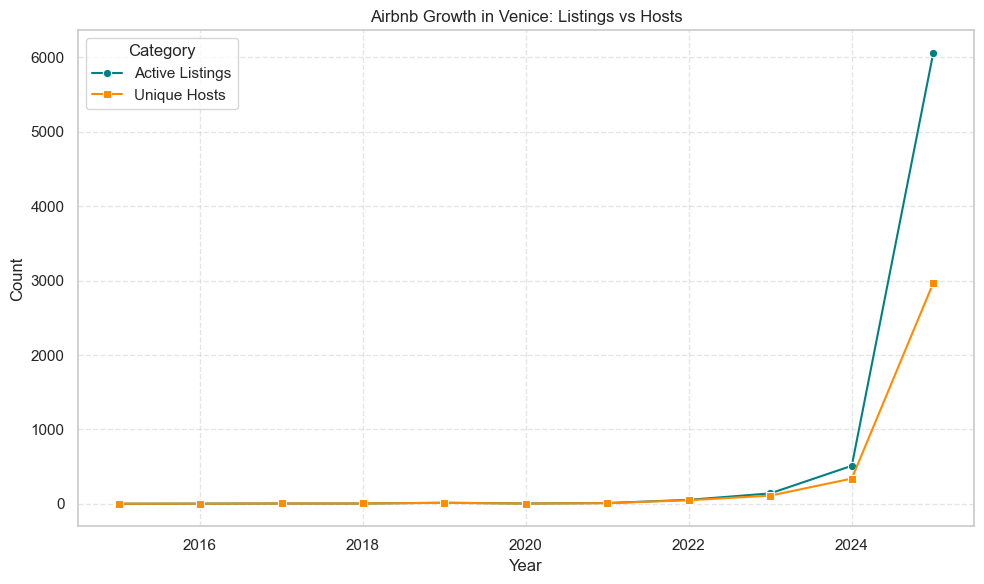

In [173]:
# Merge listings and hosts data
combined_trend = pd.merge(yearly_growth, hosts_by_year, on='review_year')

plt.figure(figsize=(10,6))
sns.lineplot(data=combined_trend, x='review_year', y='num_listings', label='Active Listings', marker='o', color='teal')
sns.lineplot(data=combined_trend, x='review_year', y='num_hosts', label='Unique Hosts', marker='s', color='darkorange')
plt.title('Airbnb Growth in Venice: Listings vs Hosts')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Category')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Observation

Both the number of active listings and the number of unique hosts have steadily increased over time, showing a consistent expansion of Airbnb’s presence in Venice.

However, the rate of growth between the two is not identical.  
While listings increase at a faster pace than hosts, this indicates that many hosts manage **multiple properties**, suggesting a gradual **professionalization** of the Airbnb market in Venice.

In economic terms:
- The market has grown in **breadth**, as more people began to use Airbnb and offer properties for rent.  
- Simultaneously, it has grown in **depth**, as existing hosts expanded their portfolios and started managing several listings at once.

After 2019, a temporary decline is visible, most likely reflecting the **impact of the COVID-19 pandemic** on tourism and travel restrictions.  
Nonetheless, the overall trend demonstrates Airbnb’s sustained diffusion and structural transformation within the Venetian housing market.

### How Have Supply and Demand Affected Airbnb Prices in Venice?

After observing how both listings (supply) and hosts have increased over time, it becomes important to understand **how this expansion has influenced prices**.  
Economic theory suggests that, as supply grows faster than demand, prices should stabilize or even decrease.  
Conversely, if demand outpaces supply — especially in a constrained environment like Venice’s historic center — prices may continue to rise despite market growth.

In this section, we compare **average prices per year** with the **number of active listings** to explore whether Airbnb prices have reflected changes in the market’s supply-demand balance.

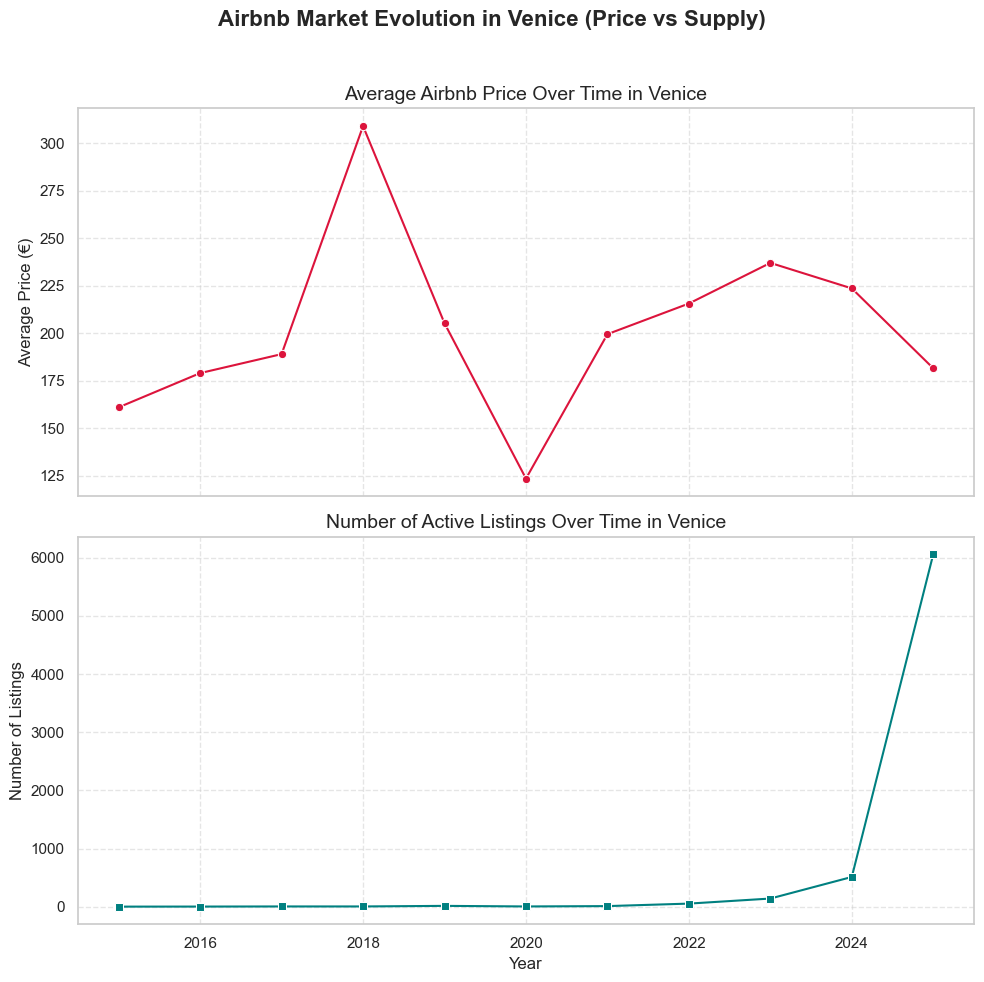

In [174]:
# Compute yearly trends for price and number of listings
price_trend = (
    df.groupby('review_year')
      .agg(avg_price=('price', 'mean'),
           num_listings=('id', 'count'))
      .reset_index()
)


fig, axs = plt.subplots(2, 1, figsize=(10,10), sharex=True)

# Subplot 1: Average Price Trend
sns.lineplot(data=price_trend, x='review_year', y='avg_price', 
             marker='o', color='crimson', ax=axs[0])
axs[0].set_title('Average Airbnb Price Over Time in Venice', fontsize=14)
axs[0].set_ylabel('Average Price (€)')
axs[0].grid(True, linestyle='--', alpha=0.5)

# Subplot 2: Number of Listings Trend
sns.lineplot(data=price_trend, x='review_year', y='num_listings', 
             marker='s', color='teal', ax=axs[1])
axs[1].set_title('Number of Active Listings Over Time in Venice', fontsize=14)
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Number of Listings')
axs[1].grid(True, linestyle='--', alpha=0.5)

# Overall formatting
plt.suptitle('Airbnb Market Evolution in Venice (Price vs Supply)', fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Observation

By separating the trends for **average prices** and **number of active listings**, we can better understand how supply and demand have evolved independently over time.

- The **number of listings** shows a strong and steady upward trajectory until 2019, confirming a rapid expansion of the Airbnb market in Venice.  
- In contrast, the **average price** remains relatively stable, suggesting that increasing competition among hosts has balanced the effect of rising demand.

After 2020, a temporary drop in both listings and prices is visible — a clear reflection of the **COVID-19 pandemic’s impact** on tourism.  
Prices recover slightly afterwards, following the market reopening, but without exceeding pre-pandemic levels.

---

### Additional Insight

The **increased Airbnb supply** has likely made Venice **more accessible to visitors**, especially in terms of short-term rental affordability.  
Following an initial alignment of Airbnb prices with the traditional accommodation market, the sustained growth in supply has helped **stabilize prices**.  

By 2025, the **average price for a 7-day stay** has returned to **levels comparable to 2016**, suggesting that the market has reached a new equilibrium — where competition among hosts counteracts inflationary pressure and maintains Venice as a viable destination for tourism without significant cost escalation.

In [175]:
price_trend.describe()

,review_year,avg_price,num_listings
count,11.000000,11.000000,11.000000
mean,2020.000000,202.177694,618.545455
std,3.316625,47.224848,1811.381151
min,2015.000000,123.500000,1.000000
25%,2017.500000,180.267613,4.000000
50%,2020.000000,199.500000,10.000000
75%,2022.500000,219.598992,96.500000
max,2025.000000,309.000000,6061.000000


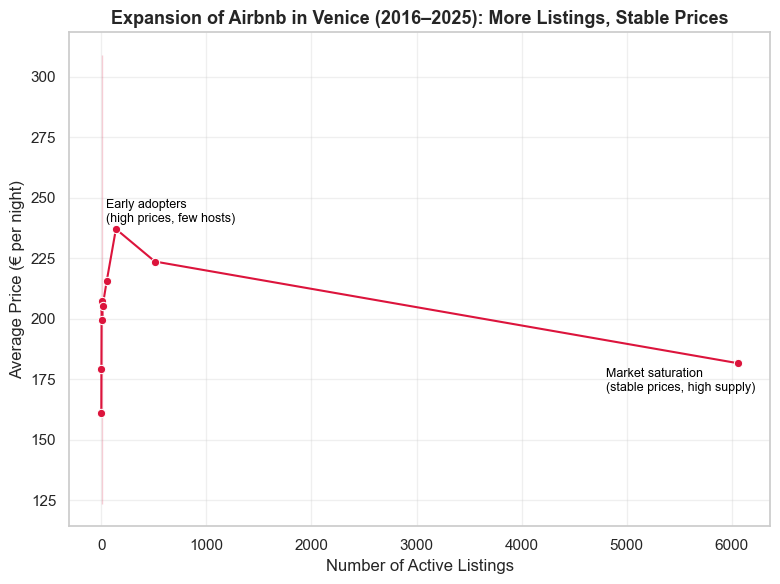

In [176]:
plt.figure(figsize=(8,6))
sns.lineplot(data=price_trend, x='num_listings', y='avg_price', color='crimson', marker='o')
plt.title('Expansion of Airbnb in Venice (2016–2025): More Listings, Stable Prices', fontsize=13, weight='bold')
plt.xlabel('Number of Active Listings')
plt.ylabel('Average Price (€ per night)')
plt.grid(alpha=0.3)

plt.text(50, 240, 'Early adopters\n(high prices, few hosts)', fontsize=9, color='black')
plt.text(4800, 170, 'Market saturation\n(stable prices, high supply)', fontsize=9, color='black')

plt.tight_layout()
plt.show()

### Observation

The data shows a **clear expansion phase** for Airbnb in Venice.

Between 2016 and 2025, the number of active listings increased dramatically, marking the platform’s diffusion across the city.  
However, despite this rapid growth, **average prices did not follow the same upward trend**.  
After an initial phase where Airbnb was a niche market with higher nightly rates, competition among hosts led to a **stabilization of prices** over time.

This suggests that:
- Airbnb moved from an early-adopter phase (few listings, high prices) to a mature, competitive market (many listings, stable or slightly decreasing prices).
- The **growth in supply** made short-term accommodation more accessible, balancing tourism affordability with the profitability of hosts.

### How do prices vary by neighbourhood?

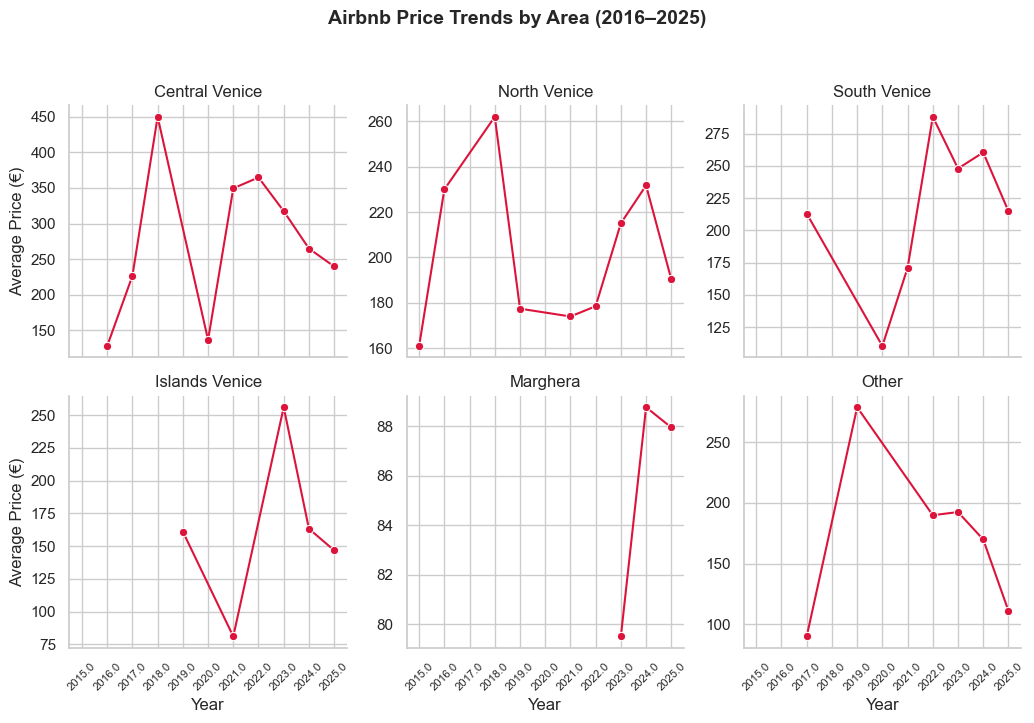

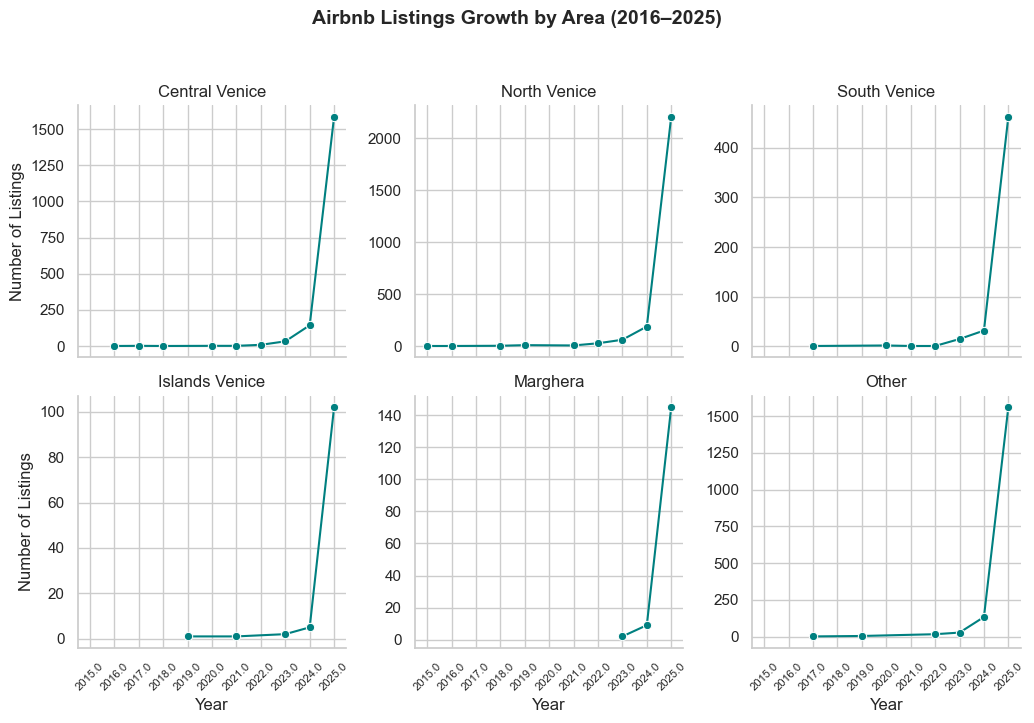

In [177]:
import seaborn as sns
import matplotlib.pyplot as plt

# === 1️⃣ Preparazione dati ===
area_trend = (
    df.groupby(['review_year', 'area'])
      .agg(avg_price=('price', 'mean'),
           listings=('id', 'nunique'))
      .reset_index()
)

# Ordine personalizzato delle aree
area_order = ['Central Venice', 'North Venice', 'South Venice', 'Islands Venice', 'Marghera', 'Other']
years = sorted(df['review_year'].dropna().unique())

sns.set_theme(style='whitegrid')

# === 2️⃣ FacetGrid 1 — Prezzo medio per area ===
g1 = sns.FacetGrid(
    area_trend,
    col='area',
    col_wrap=3,
    height=3.5,
    col_order=area_order,
    sharey=False
)
g1.map_dataframe(sns.lineplot, x='review_year', y='avg_price', color='crimson', marker='o')
g1.set_axis_labels('Year', 'Average Price (€)')
g1.set(xticks=years)
g1.set_xticklabels(years, rotation=45, fontsize=8)
g1.set_titles(col_template='{col_name}')
g1.fig.suptitle('Airbnb Price Trends by Area (2016–2025)', fontsize=14, weight='bold', y=1.03)
g1.tight_layout()
plt.show()

# === 3️⃣ FacetGrid 2 — Numero di annunci per area ===
g2 = sns.FacetGrid(
    area_trend,
    col='area',
    col_wrap=3,
    height=3.5,
    col_order=area_order,
    sharey=False
)
g2.map_dataframe(sns.lineplot, x='review_year', y='listings', color='teal', marker='o')
g2.set_axis_labels('Year', 'Number of Listings')
g2.set(xticks=years)
g2.set_xticklabels(years, rotation=45, fontsize=8)
g2.set_titles(col_template='{col_name}')
g2.fig.suptitle('Airbnb Listings Growth by Area (2016–2025)', fontsize=14, weight='bold', y=1.03)
g2.tight_layout()
plt.show()

### Observation

The evolution of Airbnb in Venice shows **strong geographical dynamics**.

- The **Central Venice** and **Islands** areas have consistently maintained higher average prices, driven by proximity to major tourist attractions and historical landmarks.  
- Meanwhile, **Marghera** and **Mainland** areas have experienced a **significant increase in listings**, offering more affordable accommodation options.
- This indicates a **spatial diffusion of Airbnb**, where growth in less central areas helped accommodate increasing demand while keeping prices stable citywide.

Overall, the data suggests that Airbnb contributed to a **redistribution of tourism flows**, extending beyond the historic center and promoting a more balanced hospitality market.

### How the booking trended over the year for top 5 reviewed host facilities?

/var/folders/sn/xrsxvpkj4bx6b_6m3_7zbjz80000gn/T/ipykernel_83081/3187085770.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


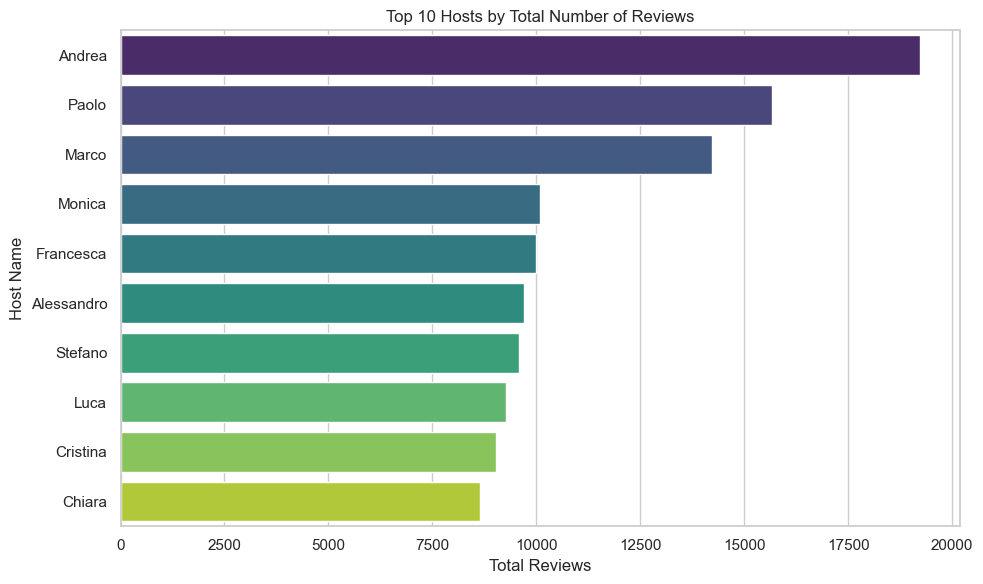

In [178]:
top_hosts = (
    df.groupby('host_name')['number_of_reviews']
      .sum()                              # somma tutte le recensioni per host
      .sort_values(ascending=False)        # ordina in modo decrescente
      .head(10)                            # prendi i primi 10
      .reset_index()
)

plt.figure(figsize=(10,6))
sns.barplot(
    data=top_hosts,
    x='number_of_reviews',
    y='host_name',
    palette='viridis'
)
plt.title('Top 10 Hosts by Total Number of Reviews')
plt.xlabel('Total Reviews')
plt.ylabel('Host Name')
plt.tight_layout()
plt.show()

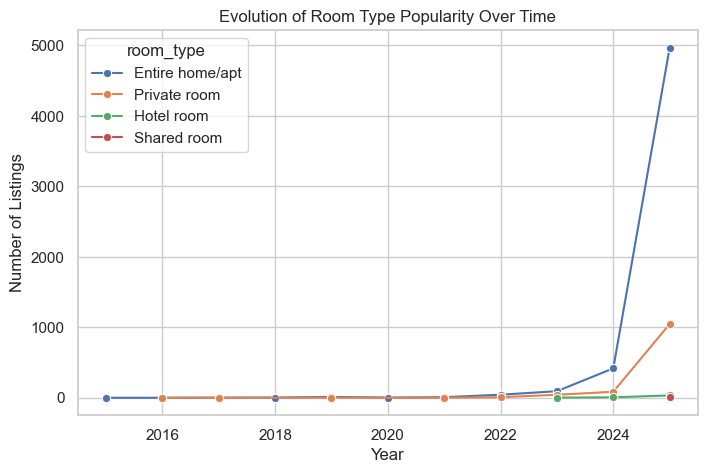

In [179]:
room_trend = (
    df.groupby(['review_year', 'room_type'])
      .size()
      .reset_index(name='count')
)
plt.figure(figsize=(8,5))
sns.lineplot(data=room_trend, x='review_year', y='count', hue='room_type', marker='o')
plt.title('Evolution of Room Type Popularity Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Listings')
plt.show()

## 6. (Optional) Model — Price Prediction

In [185]:
# Copy clean dataset
model_df = df.copy()

# Select relevant variables
model_df = model_df[['price', 'room_type', 'area', 'number_of_reviews']].dropna()

# Encode categorical variables
model_df = pd.get_dummies(model_df, columns=['room_type', 'area'], drop_first=True)

model_df.head()

,price,number_of_reviews,room_type_Hotel room,room_type_Private room,room_type_Shared room,area_Islands Venice,area_Marghera,area_North Venice,area_Other,area_South Venice
0,294.0,90,False,False,False,False,False,False,False,False
1,205.0,202,False,False,False,False,False,False,False,True
2,372.0,150,False,False,False,False,False,True,False,False
3,122.0,429,True,False,False,False,False,False,False,True
4,150.0,140,False,False,False,False,False,False,False,False


In [181]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

# Split X / y
X = model_df.drop('price', axis=1)
y = model_df['price']

# Split train / test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
lm = LinearRegression()
lm.fit(X_train, y_train)

# Predict
y_pred = lm.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R² Score: {r2:.2f}")
print(f"Mean Absolute Error: €{mae:.2f}")

R² Score: 0.21
Mean Absolute Error: €71.02


In [182]:
# Get coefficients
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lm.coef_
}).sort_values(by='Coefficient', ascending=False)

coefficients.head(10)

,Feature,Coefficient
0,number_of_reviews,-0.107529
1,room_type_Hotel room,-26.099560
8,area_South Venice,-27.198943
6,area_North Venice,-48.049604
2,room_type_Private room,-63.526849
3,room_type_Shared room,-66.800336
4,area_Islands Venice,-101.205470
7,area_Other,-117.072155
5,area_Marghera,-138.047745


/var/folders/sn/xrsxvpkj4bx6b_6m3_7zbjz80000gn/T/ipykernel_83081/95065624.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=coefficients, y='Feature', x='Coefficient', palette='viridis')


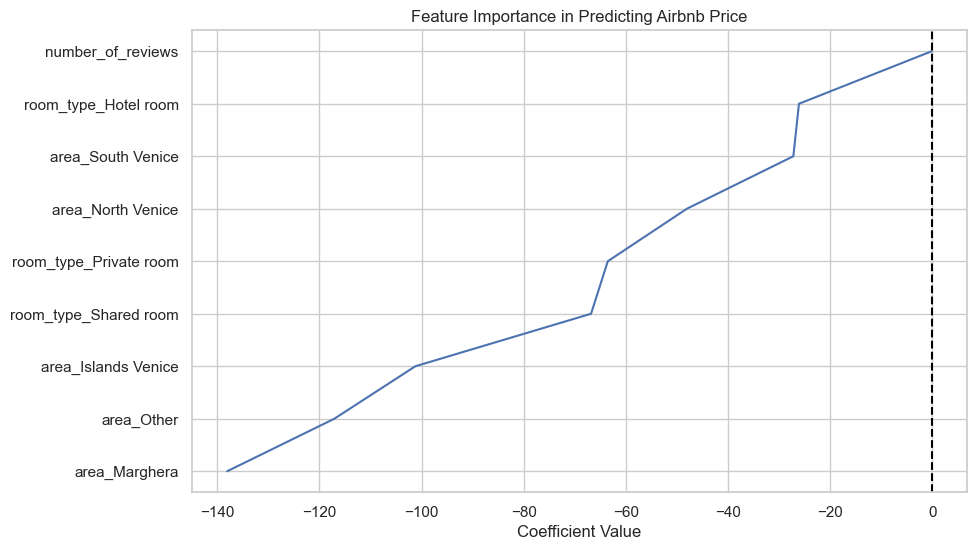

In [184]:
plt.figure(figsize=(10,6))
sns.lineplot(data=coefficients, y='Feature', x='Coefficient', palette='viridis')
plt.title('Feature Importance in Predicting Airbnb Price')
plt.xlabel('Coefficient Value')
plt.ylabel('')
plt.axvline(0, color='black', linestyle='--')
plt.show()

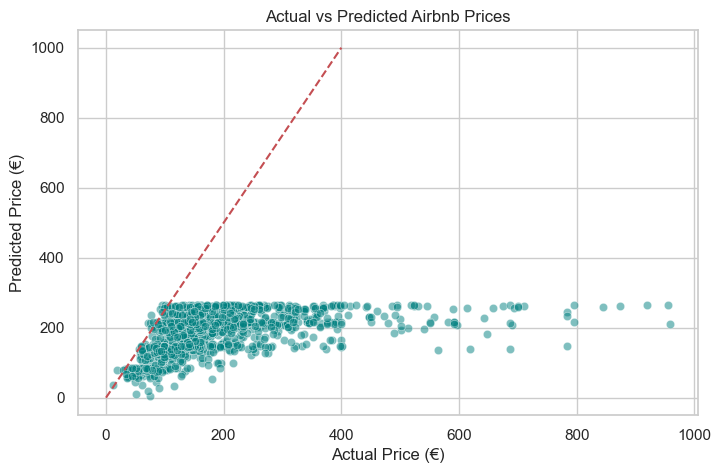

In [187]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, color='teal')
plt.title('Actual vs Predicted Airbnb Prices')
plt.xlabel('Actual Price (€)')
plt.ylabel('Predicted Price (€)')
plt.plot([0,400], [0,1000], 'r--')  # linea ideale
plt.show()

## 7. Visualize — Key Insights


Use clear, polished plots to support your findings.

Examples:
- Price vs. Room Type
- Price vs. Review Count
- Price vs. Location
- Correlation Heatmap
    

In [ ]:

corr = df[['price', 'number_of_reviews', 'review_scores_rating']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()
    


## 8. Conclusion

- Prices vary significantly across neighbourhoods.
- Entire apartments are priced higher than private rooms.
- Positive reviews correlate with slightly higher prices.
- Some listings contain inconsistent data and should be reviewed further.
    


## 9. Appendix — References & Acknowledgements

**Data Source:** [Inside Airbnb](http://insideairbnb.com/get-the-data.html)  
**Author:** Luca Scarpantonio  
**Project:** Introduction to Data Science Nanodegree (Udacity)
    